### 참고 : Collaborative Filtering for Implicit Feedback Datasets - Yifan Hu

http://yifanhu.net/PUB/cf.pdf

In [1]:
import pandas as pd
import numpy as np
import os.path
import csv
import operator

In [2]:
# 영화 300개 자료 저장
# User 수는 1000명
data = {}
movie_id = 0
user_name = 0
rating = 0
user_list = []


with open('combined_data_1.txt', 'r') as f:
    for line in f:
        if(line.find(":") != -1):
            continue
        line_split = line.split(',')
        user_name = int(line_split[0])
        if user_name in user_list:
            continue
        else:
            user_list.append(user_name)
        if len(user_list) > 1000:
            break

with open('combined_data_1.txt', 'r') as f:
    for line in f:
        if(line.find(":") != -1):
            movie_id = int(line.replace(":","")) - 1
            if(movie_id >= 300): break
            data[movie_id] = {}
        else:
            line_split = line.split(',')
            user_name = int(line_split[0])
            rating = int(line_split[1])
            if user_name in user_list:
                data[movie_id][user_name] = rating

#### Explicit Feedback data X

In [3]:
Matrix = np.nan_to_num(np.array(pd.DataFrame(data)))

Matrix

array([[3., 0., 0., ..., 0., 3., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 5., ..., 0., 0., 0.],
       [0., 0., 3., ..., 0., 0., 0.],
       [0., 0., 4., ..., 0., 5., 0.]])

#### 선호도 행렬 P

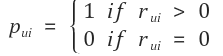

In [4]:
# Raiting 값이 존재하면 1 / 존재하지 않으면 0으로 초기화
P = np.copy(Matrix)
P[P > 0] = 1
print(P)

[[1. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]]


#### 신뢰도 행렬 C

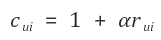

In [5]:
# alpha = 40 으로 초기화(논문에서 좋은 결과가 나온 값)
C = 1 + 40 * Matrix
print(C)
print()

[[121.   1.   1. ...   1. 121.   1.]
 [201.   1.   1. ...   1.   1.   1.]
 [161.   1.   1. ...   1.   1.   1.]
 ...
 [  1.   1. 201. ...   1.   1.   1.]
 [  1.   1. 121. ...   1.   1.   1.]
 [  1.   1. 161. ...   1. 201.   1.]]



### Loss Function

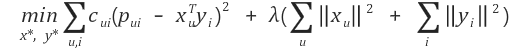

In [6]:
def loss_function(C, P, xTy, lambda_, X, Y):
    predict_error = np.square(P - xTy) # P - xTy => 실제값 - 예측값
    return np.sum(predict_error), np.sum(C * predict_error) + lambda_ * (np.sum(np.square(X)) + np.sum(np.square(Y)))

#### Optimize user factors



#### Optimize item factors



In [7]:
def optimize(X, Y, C, P, num_of_user, num_of_item, dimension, lambda_):
    # user
    yT = np.transpose(Y)
    D = np.dot(lambda_, np.identity(dimension)) # lambda * identity_matirix
    for u in range(num_of_user):
        yT_Cu_y_D_inverse = np.linalg.inv(np.dot(np.dot(yT, np.diag(C[u])), Y) + D) # (yTCuY + D)의 역행렬
        yT_Cu_pu = np.dot(np.dot(yT, np.diag(C[u])), P[u])
        X[u] = np.dot(yT_Cu_y_D_inverse, yT_Cu_pu)
    
    # item
    xT = np.transpose(X)
    for i in range(num_of_item):
        xT_Ci_x_D_inverse = np.linalg.inv(np.dot(np.dot(xT, np.diag(C[:, i])), X) + D) # (xT_Ci_x + D)의 역행렬
        xT_Ci_pi = np.dot(np.dot(xT, np.diag(C[:, i])), P[:, i])
        Y[i] = np.dot(xT_Ci_x_D_inverse, xT_Ci_pi)

#### 각 파라미터별 최적값 확인
- predict_error로 확인

In [8]:
# 각 파라미터별 total_loss
result = []

# 정규화에 필요한 lambda
lambda_ = [i for i in range(10,30,10)]

# Latent Factor 행렬의 차원
dimension = [i for i in range(10,410,40)]

# Latent Factor 행렬의 차원
alpha_ = [i for i in range(10,50,10)]

# user, item 수 
num_of_user, num_of_item = Matrix.shape[0], Matrix.shape[1]

for a in alpha_:
    for d in dimension:
        for l in lambda_:
            # Latent Factor Matrix 초기 랜덤값 생성
            # X : 유저
            # Y : 영화
            np.random.seed(100)
            X = np.random.rand(num_of_user, d) * 0.01
            Y = np.random.rand(num_of_item, d) * 0.01

            C = 1 + a * Matrix
            temp_losses = 10000000
            temp_predict_error = 10000000

            print('dimension : %d, lambda : %d, alpha : %d' %(l,d,a))
            print()
            i = 0
            while(True):
                i += 1
                print('---step %d---' % i)
                if i!=0:    
                    optimize(X, Y, C, P, num_of_user, num_of_item, d, l)
                    predict = np.dot(X, np.transpose(Y))
                    predict_error, total_loss = loss_function(C, P, predict,l,X,Y)

                    if temp_predict_error < predict_error:
                        break                
                    if temp_losses - total_loss < 1000 or i == 10: # Overfitting 방지
                        break

                temp_predict_error = predict_error
                temp_losses = total_loss

            print("total loss: %f" % total_loss)
            print("predict_error: %f" % predict_error)
            print()
            print()

            result.append([d,l,a,predict_error])

lambda : 10, dimension : 10 alpha : 10

---step 1---
---step 2---
total loss: 79836.537725
predict_error: 23910.747310


lambda : 20, dimension : 10 alpha : 10

---step 1---
---step 2---
total loss: 87987.801473
predict_error: 23561.789997


lambda : 10, dimension : 50 alpha : 10

---step 1---
---step 2---
---step 3---
---step 4---
---step 5---
---step 6---
total loss: 29796.383037
predict_error: 7765.368555


lambda : 20, dimension : 50 alpha : 10

---step 1---
---step 2---
---step 3---
---step 4---
---step 5---
---step 6---
---step 7---
total loss: 43524.086629
predict_error: 8344.373881


lambda : 10, dimension : 90 alpha : 10

---step 1---
---step 2---
---step 3---
---step 4---
---step 5---
total loss: 25357.717392
predict_error: 3338.720629


lambda : 20, dimension : 90 alpha : 10

---step 1---
---step 2---
---step 3---
---step 4---
---step 5---
---step 6---
total loss: 41952.954351
predict_error: 4889.699461


lambda : 10, dimension : 130 alpha : 10

---step 1---
---step 2---
---

---step 5---
total loss: 43019.391230
predict_error: 4538.160467


lambda : 10, dimension : 290 alpha : 30

---step 1---
---step 2---
---step 3---
---step 4---
total loss: 27498.060404
predict_error: 2327.826380


lambda : 20, dimension : 290 alpha : 30

---step 1---
---step 2---
---step 3---
---step 4---
---step 5---
total loss: 43687.668680
predict_error: 4514.142140


lambda : 10, dimension : 330 alpha : 30

---step 1---
---step 2---
---step 3---
---step 4---
total loss: 28235.242496
predict_error: 2293.141578


lambda : 20, dimension : 330 alpha : 30

---step 1---
---step 2---
---step 3---
---step 4---
---step 5---
total loss: 44138.722558
predict_error: 4503.942744


lambda : 10, dimension : 370 alpha : 30

---step 1---
---step 2---
---step 3---
---step 4---
total loss: 28754.473365
predict_error: 2325.848804


lambda : 20, dimension : 370 alpha : 30

---step 1---
---step 2---
---step 3---
---step 4---
---step 5---
total loss: 44880.938810
predict_error: 4467.926305


lambda : 10,

In [9]:
# predict_error 
pd.DataFrame(result).sort_values(by = [3])

,0,1,2,3
10,210,10,10,1942.943503
12,250,10,10,1955.528158
8,170,10,10,1959.821126
14,290,10,10,1973.107493
16,330,10,10,1981.232615
...,...,...,...,...
20,10,10,20,37839.104116
41,10,20,30,40299.344481
40,10,10,30,47214.502363
61,10,20,40,48741.004425


- 가장 이상적인 초기값
    - dimension = 210
    - lambda_ = 10
    - alpha = 10

### 최종 모델

In [11]:
# lambda_ = 10
l = 10
# dimension = 210
d = 210
alpha = 10

# user, item 수 
num_of_user, num_of_item = Matrix.shape[0], Matrix.shape[1]

# Latent Factor Matrix 초기 랜덤값 생성
# X : 유저
# Y : 영화
np.random.seed(100)
X = np.random.rand(num_of_user, d) * 0.01
Y = np.random.rand(num_of_item, d) * 0.01

C = 1 + alpha * Matrix
temp_losses = 10000000
temp_predict_error = 10000000

print('lambda : %d, dimension : %d' %(l,d))
print()
i = 0
while(True):
    i += 1
    print('---step %d---' % i)
    if i!=0:    
        optimize(X, Y, C, P, num_of_user, num_of_item, d, l)
        predict = np.dot(X, np.transpose(Y))
        predict_error, total_loss = loss_function(C, P, predict,l,X,Y)

        if temp_predict_error < predict_error:
            break                
        if temp_losses - total_loss < 1000 or i == 10:
            break

    temp_predict_error = predict_error
    temp_losses = total_loss

print("total loss: %f" % total_loss)
print("predict_error: %f" % predict_error)
print()
print()

result_matrix = np.dot(X, np.transpose(Y))

lambda : 10, dimension : 210

---step 1---
---step 2---
---step 3---
---step 4---
total loss: 23281.268019
predict_error: 1942.943503




In [22]:
# 최종 예측값
predict = pd.DataFrame(result_matrix)
predict.iloc[:10,:10]

,0,1,2,3,4,5,6,7,8,9
0,0.990046,0.198061,0.212851,0.028474,0.039580,0.192591,0.029017,0.973627,0.105254,-0.103369
1,0.978127,-0.071150,-0.103485,0.005360,0.002237,-0.007204,0.013487,0.025168,-0.002813,0.010658
2,0.983041,0.102815,-0.038222,-0.058152,0.920232,0.114736,-0.012939,0.052261,0.019089,0.016193
3,0.992375,0.086655,0.152055,-0.056535,0.753697,0.097807,-0.011138,-0.002097,0.000913,-0.015046
4,0.981479,0.197987,0.188059,0.018772,0.001706,0.049316,-0.035248,0.901856,-0.044796,0.016373
5,0.989451,0.118670,0.187099,0.001756,0.037209,0.101098,0.016376,0.123127,-0.003510,-0.068534
6,0.985814,-0.007074,-0.040777,0.018928,0.015590,-0.002111,0.004160,0.068630,-0.003450,-0.002245
7,0.995922,-0.000328,-0.071534,0.011828,0.087657,-0.013616,0.040515,0.024319,-0.014468,-0.030751
8,0.989243,0.113568,0.113001,-0.006745,0.064438,-0.015276,0.003515,0.132048,0.003447,-0.011738
9,0.971176,-0.070644,-0.102749,0.005322,0.002221,-0.007153,0.013392,0.024989,-0.002793,0.010582


In [23]:
pd.DataFrame(Matrix).iloc[:10,:10]

,0,1,2,3,4,5,6,7,8,9
0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- 위의 결과값과 실제 Rating값을 비교해보면 Raiting값이 있을 경우 예측값은 1에 가깝고 없는 경우 0에 가깝다.
- Raiting이 없는 값중에 예측값이 1에 가까우면 추천

#### 예시) user = 0 

In [63]:
# Rating이 없는 값 중 예측값 확인
Test = np.copy(Matrix)
Test[Test == 0] = -1
Test[Test > 0] = 0
Test[Test < 0] = 1
(predict * Test)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.000000,0.198061,0.212851,0.028474,0.039580,0.192591,0.029017,0.000000,0.105254,-0.103369,...,-0.036394,0.253148,-0.023703,0.009244,0.217782,-0.033534,0.048648,0.032442,0.000000,0.042164
1,0.000000,-0.071150,-0.103485,0.005360,0.002237,-0.007204,0.013487,0.025168,-0.002813,0.010658,...,0.001345,-0.013040,0.010032,-0.033087,0.003904,0.025807,-0.003876,0.018369,0.026196,-0.005332
2,0.000000,0.102815,-0.038222,-0.058152,0.000000,0.114736,-0.012939,0.052261,0.019089,0.016193,...,0.084161,0.057057,-0.099870,-0.059629,0.074814,0.012655,0.000000,0.015940,0.028457,-0.041020
3,0.000000,0.086655,0.152055,-0.056535,0.000000,0.097807,-0.011138,-0.002097,0.000913,-0.015046,...,0.030711,0.074229,0.059497,0.034581,0.325895,0.052772,0.160295,0.054738,0.000000,-0.024661
4,0.000000,0.197987,0.188059,0.018772,0.001706,0.049316,-0.035248,0.000000,-0.044796,0.016373,...,-0.013568,0.050493,0.001181,0.013551,0.119313,0.001635,0.039184,0.023053,0.245213,-0.031987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.136358,0.114995,0.000000,0.008873,-0.069068,0.105528,0.022008,0.083375,0.076550,0.142308,...,-0.015526,0.077160,0.089827,0.178674,0.154045,0.005356,0.091487,0.039763,0.000000,0.019580
997,0.010713,0.050310,0.000000,-0.029178,0.038497,-0.025289,-0.000510,0.062069,0.034392,0.102724,...,-0.012304,0.062689,0.000502,0.043852,-0.015912,0.034289,0.090060,0.012826,0.155788,0.016913
998,-0.064336,0.026340,0.000000,0.014294,-0.030449,0.138030,0.007172,0.033306,0.001112,0.084504,...,-0.012115,-0.066581,0.202405,0.215998,-0.012067,-0.009559,0.133812,-0.036132,0.123027,0.022776
999,-0.047714,-0.094503,0.000000,0.041351,-0.090336,-0.046905,0.016197,0.000000,-0.006875,0.063495,...,-0.028000,0.002040,-0.127985,-0.105107,0.089016,0.024869,-0.064380,0.120131,0.062767,0.005340


- 각 영화별 예측값 정렬후 원하는 수만큼 위에서부터 영화 추천

- user = 0 인 경우에 영화 3개를 추천할 때 268,165,126인 영화를 추천

In [65]:
(predict * Test).iloc[0,:].sort_values(ascending = False)

268    0.456564
165    0.433882
126    0.421913
160    0.347012
95     0.305039
         ...   
113   -0.102080
9     -0.103369
263   -0.107994
191   -0.119782
112   -0.128457
Name: 0, Length: 300, dtype: float64